In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# utils_1D.py contains the common functions and classes used in 1D case
from utils_1D import FNN, plot_2D, x_train_data

2023-08-14 14:54:07.994857: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-14 14:54:08.035050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 14:54:08.569394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tao = 4E-2 # time step
k = 1.     # physical constant

fu = lambda u: 0.5*k*u**2 # free energy density

Nx = 100 # number of grid points, samples of x
X = x_train_data(Nx) # training data 

2023-08-14 14:54:13.386277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2588 MB memory:  -> device: 0, name: NVIDIA T400 4GB, pci bus id: 0000:d5:00.0, compute capability: 7.5


In [4]:
# Network structure 
n_out = 1     # number of output nodes
n_layer = 2   # number of hidden layers
n_nodes = 20  # number of nodes in each hidden layer

# Create a list of networks, each corresponding to a time step
Net_list = []
for i in range(20):
    Net_list.append(FNN(n_out, n_layer, n_nodes, 'relu'))

In [5]:
# training step to minimize the loss function
def train_step_physics_informed(net0, net1, x, optimizer):
    
    with tf.GradientTape() as g:
        up = net0(x)
        uq = net1(x)

        loss_energy   = tf.reduce_mean( fu(uq) )*2
        loss_distance = tf.reduce_mean((uq - up)**2)/tao/2*2

        loss = loss_energy + loss_distance

    grads = g.gradient(loss, net1.trainable_variables)

    optimizer.apply_gradients(zip(grads, net1.trainable_variables))
        
    return loss_energy, loss_distance, loss

In [6]:
# Training process: network trained one by one in sequence
nepochs = 1500
for i, net_train in enumerate(Net_list):
    if i == 0:
        net_pre = lambda x: tf.sin(np.pi*x)
    else:
        net_pre = Net_list[i-1]
    print('training net: ', i+1)
    optimizer = tf.optimizers.Adam(learning_rate=0.001)
    for epoch in range(nepochs):

        loss_energy, loss_distance, loss = train_step_physics_informed(net_pre, net_train, X, optimizer)

        if (epoch+1) % 500 == 0:    
            print(f'Epoch :{epoch+1}, Loss:{loss:.4e}, energy:{loss_energy:.4e}, distance: {loss_distance:.4e}')

training net:  1


2023-08-14 14:54:30.589665: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x3c4b8520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-14 14:54:30.589691: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA T400 4GB, Compute Capability 7.5
2023-08-14 14:54:30.593435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-14 14:54:30.706369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-14 14:54:30.812956: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch :500, Loss:6.9139e-01, energy:4.3614e-01, distance: 2.5525e-01
Epoch :1000, Loss:4.9174e-01, energy:4.6816e-01, distance: 2.3576e-02
Epoch :1500, Loss:4.8938e-01, energy:4.6920e-01, distance: 2.0175e-02
training net:  2
Epoch :500, Loss:4.6832e-01, energy:4.2621e-01, distance: 4.2106e-02
Epoch :1000, Loss:4.5152e-01, energy:4.3350e-01, distance: 1.8022e-02
Epoch :1500, Loss:4.5130e-01, energy:4.3374e-01, distance: 1.7560e-02
training net:  3
Epoch :500, Loss:6.1340e-01, energy:3.7164e-01, distance: 2.4176e-01
Epoch :1000, Loss:4.1895e-01, energy:3.9974e-01, distance: 1.9210e-02
Epoch :1500, Loss:4.1742e-01, energy:4.0075e-01, distance: 1.6672e-02
training net:  4
Epoch :500, Loss:4.2245e-01, energy:3.5911e-01, distance: 6.3346e-02
Epoch :1000, Loss:3.8581e-01, energy:3.7009e-01, distance: 1.5721e-02
Epoch :1500, Loss:3.8540e-01, energy:3.7043e-01, distance: 1.4972e-02
training net:  5
Epoch :500, Loss:3.7467e-01, energy:3.3532e-01, distance: 3.9349e-02
Epoch :1000, Loss:3.5648e-0

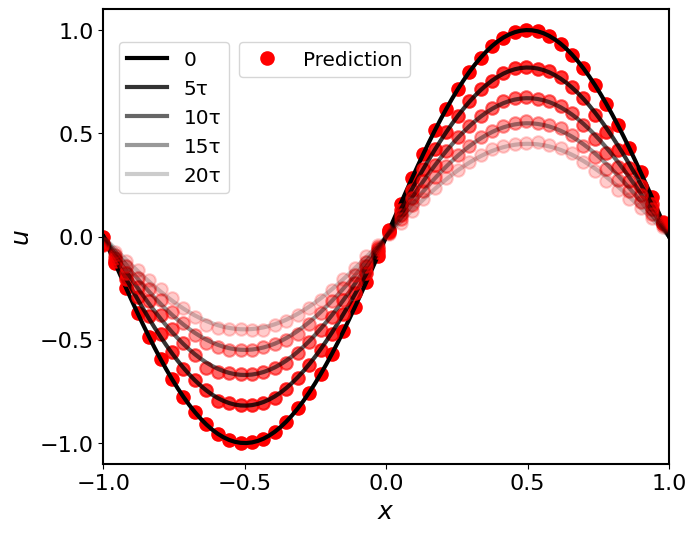

In [7]:
X = tf.linspace(-1., 1., 100)
X = tf.reshape(X, (-1, 1))

xlim = [-1, 1]
ylim = [-1.1, 1.1]
xticks = [-1.0, -0.5, 0, 0.5, 1.0]
yticks = xticks
xlabel = r"$\mathit{x}$"
ylabel = r"$\mathit{u}$"

fig, ax = plot_2D(xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks, xlabel=xlabel, ylabel=ylabel)

for i in range(21):

    if (i == 0):
        u_pred = tf.sin(np.pi*X)
        
    else:   
        u_pred = Net_list[i-1](X)

    u_exact = np.exp(-k*tao*i)*np.sin(X*np.pi)
    
    if i % 5 == 0 :

        ln1, = ax.plot(X, u_pred, 'ro', markevery=2, markersize=9, 
            markeredgewidth=1.5, markerfacecolor=[1, 0, 0, 1 - 0.04*i])
        if i == 0:
            label_tao = f'{i:d}'
            ln = ln1
        else:
            label_tao = f'{i:d}' + '\u03C4'
        ln2, = ax.plot(X, u_exact, 'k', linewidth = 3, alpha=1 - 0.04*i, label = label_tao)


leg1 = ax.legend([ln], ['Prediction'], fontsize='x-large',  loc='upper right', bbox_to_anchor=(0.56, 0.95))
ax.legend(fontsize='x-large', bbox_to_anchor=(0.24, 0.95))

#ax.legend([ln1, ln2], ['Prediction', 'Ground Truth'], fontsize='large')
ax.add_artist(leg1)
# add colorbar bar on the right with custom ticks
# Create a list of transparency values for the curves
transparency_values = [1 - 0.016 * i for i in range(51)]

#plt.savefig('1D_PINN.png', dpi=300)

In [8]:
# compare the free energy of the true solution and the prediction
t = np.array([i*tao for i in range(21)]).reshape(-1, 1)
F_true = []
F_pred = []
for i, ti in enumerate(t):
    if i == 0:
        u_pred = tf.sin(np.pi*X)
    else:
        u_pred = Net_list[i-1](X)
    u_exact = np.exp(-k*ti)*np.sin(X*np.pi)
    F_true.append(tf.reduce_mean(0.5*u_exact**2)*2)
    F_pred.append(tf.reduce_mean(0.5*u_pred**2)*2)


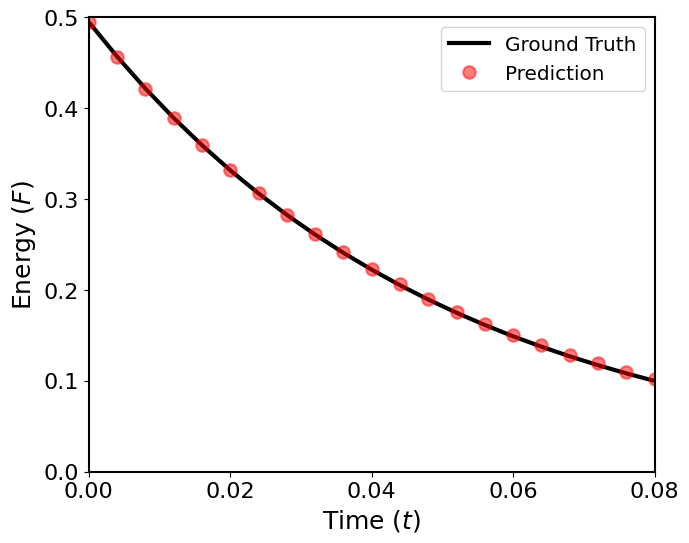

In [9]:
xlim = [0, 0.08]
ylim = [0, 0.5]
xticks = [0, 0.02, 0.04, 0.06, 0.08]
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
xlabel = r"Time ($\mathit{t})$"
ylabel = r"Energy ($\mathit{F})$"

fig, ax = plot_2D(xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks, xlabel=xlabel, ylabel=ylabel)

ln1, = ax.plot(t/10, F_true, 'k', linewidth = 3, label = r"Ground Truth" )
ln2, = ax.plot(t/10, F_pred, 'ro', alpha=0.5, label = r"Prediction", markersize=9, 
            markeredgewidth=1.5, markerfacecolor=[1, 0, 0, 0.5])

plt.legend(fontsize='x-large')
#plt.savefig('1D_Map_energy.png', dpi=300)